# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** до 27 ноября 2017, 23:59   
**Штраф за опоздание:** -2 балла после 23:59  4 декабря, -4 балла после 23:59 11 декабря, -6 баллов после 23:59 18 декабря

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Разбаловка:**   
За задание можно получить 10 баллов. Для этого нужно следующее:
1. Там, где написано "Ваш код", нужно реализовать метод или часть метода
2. Там, где написано "Что делает этот блок кода?", нужно разобраться в блоке кода и в комментарии написать, что он делает    
3. Добиться, чтобы в пункте "Проверка скорости работы" Ваша реализация работала чуть быстрее, чем у дерева из sklearn
4. Добиться, чтобы в пункте "Проверка качества работы" Ваша реализация работала качественнее, чем у дерева из sklearn

In [2]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import optimize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [46]:

class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, sufficient_share=1.0, criterion='gini', max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print 'invalid criterion name'
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features == None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print 'invalid max_features name'
            raise

    def __gini(self, l_c, l_s, r_c, r_s):

        l_s = l_s.astype('float')
        r_s = r_s.astype('float')

        l_gini = 1.0 - np.nansum((l_c / l_s) ** 2, axis=1 )
        r_gini = 1.0 - np.nansum((r_c / r_s) ** 2, axis=1)
        return l_gini * (l_s / (l_s + r_s)).ravel() + r_gini * (r_s / (l_s + r_s)).ravel()

    def __entropy(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')

        l_scores = l_c / l_s

        r_scores = r_c / r_s
        l_scores[l_scores == 0.0] = 1.0
        r_scores[r_scores == 0.0] = 1.0


        entropy_l = -1.0 * np.nansum(l_scores * np.log(l_scores), axis=1)
        entropy_r = -1.0 * np.nansum(r_scores * np.log(r_scores), axis=1)

        return entropy_l * (l_s / (l_s + r_s)).ravel() + entropy_r * (r_s / (l_s + r_s)).ravel()

    def __misclass(self, l_c, l_s, r_c, r_s):

        l_s = l_s.astype('float')
        r_s = r_s.astype('float')

        misclass_l = 1 - np.nanmax(l_c / l_s, axis = 1)
        misclass_r = 1 - np.nanmax(r_c / r_s, axis = 1)

        return misclass_l * (l_s / (l_s + r_s)).ravel() + misclass_r * (r_s / (l_s + r_s)).ravel()  # Ваш код


    def __get_feature_ids_sqrt(self, n_feature):

        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)

        return feature_ids[:np.sqrt(n_feature)]  # Ваш код

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)

        return feature_ids[:np.log2(n_feature)]  # Ваш код

    def __get_feature_ids_N(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)

        return feature_ids  # Ваш код

    def __sort_samples(self, x, y):
        sorted_idx = x.argsort(axis=0)
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        # Что делает этот блок кода?
        # Сортируем целевую переменную(y)  по значению признака (x) 
        sorted_x, sorted_y = self.__sort_samples(x, y)

        # class_number = np.unique(y).shape[0]
        # Количество различных классов
        class_number = self.num_class
        
        # отбрасываем слева и справа то количество элементов, которое не сможем разделить, так как оно меньше 
        # чем min_samples_split
        splitted_sorted_y = sorted_y[self.min_samples_split: -self.min_samples_split]
        
        # теперь рассматриваем полученный урезанный массив и находим индексы тех элементов,
        # на которых происходит смена класса
        # т.е. например для splitted_sorted_y = [0 0 0 0 1 0 1 1] ->  r_border_ids = [4 5 6] 
        r_border_ids = np.where(splitted_sorted_y[:-1] != splitted_sorted_y[1:])[0] + (self.min_samples_split + 1)
        # если класс всех елементов одинаков либо splitted_sorted_y пуст то разделить выборку нельзя, 
        # поэтому возвращаем impurity index = +inf 
        if len(r_border_ids) == 0:
            return float('+inf'), None

        # Что делает этот блок кода?
        # считаем количество последовательно идущих элементов с одинаковыми классами, 
        # отдельно для каждой такой группы, кроме последней 
        eq_el_count = r_border_ids - np.append([self.min_samples_split], r_border_ids[:-1])

        # для каждой группы элментов с одинаковыми классами, кроме последнего, 
        # ставим единицу на место (i,j) где i - номер группы, а j - номер класса 
        one_hot_code = np.zeros((r_border_ids.shape[0], class_number))
        one_hot_code[np.arange(r_border_ids.shape[0]), sorted_y[r_border_ids - 1]] = 1

        # считаем количество элментов каждого класса в каждой группе
        class_increments = one_hot_code * eq_el_count.reshape(-1, 1)
        # к первой группе добавляем счетчик классов из левой выкинутой ранее границы
        class_increments[0] = class_increments[0] + np.bincount(sorted_y[:self.min_samples_split],
                                                                minlength=class_number)

        # Что делает этот блок кода?
        # Считаем гранцы групп - границами по которым проходят разбиения на правую и левую часть
        # Считаем колчество элементов каждого класса слева и справа от каждой границы 
        l_class_count = np.cumsum(class_increments, axis=0)
        r_class_count = np.bincount(sorted_y, minlength=class_number) - l_class_count
        # размеры разбиений сколько элементов слева и сколько справа элементов
        l_sizes = r_border_ids.reshape(l_class_count.shape[0], 1)
        r_sizes = sorted_y.shape[0] - l_sizes

        # Что делает этот блок кода?
        # находим оптимальное разбиение, с наименьшим impurity
        gs = self.G_function(l_class_count, l_sizes, r_class_count, r_sizes)
        idx = np.argmin(gs)

        # Что делает этот блок кода?
        # Находим индекс элемента слева от границы 
        left_el_id = l_sizes[idx][0]
        # возвращаем полученную минимальныую imurity и threshold
        return gs[idx], (sorted_x[left_el_id - 1] + sorted_x[left_el_id]) / 2.0

    def __set_leaf(self, x, y, node_id):
        class_probs = np.bincount(y).astype('float') / y.shape[0]
        class_with_max_prob = np.argmax(class_probs)
        self.tree[node_id] = [self.LEAF_TYPE, class_with_max_prob, class_probs]

        pass

    def __fit_node(self, x, y, node_id, depth, pred_f=-1):
        # Ваш код
        # Необходимо использовать следующее:
        # self.LEAF_TYPE
        # self.NON_LEAF_TYPE
        # self.tree
        # self.max_depth
        # self.sufficient_share
        # self.min_samples_split
        # self.get_feature_ids
        # self.__find_threshold
        # self.__div_samples
        # self.__fit_node

        if x.shape[0] < 2 * self.min_samples_split + 2 or np.unique(y).shape[0] == 1:
            self.__set_leaf(x, y, node_id)
            return

        # проверка, является ли вершина листовой
        if depth >= self.max_depth is not None:
            self.__set_leaf(x, y, node_id)
            return

        if np.max(np.bincount(y).astype('float') / y.shape[0]) >= self.sufficient_share:
            self.__set_leaf(x, y, node_id)
            return

        feature_ids = self.get_feature_ids(x.shape[1])
        th_results = np.array([self.__find_threshold(x[:, i], y) for i in feature_ids])
        impurities = th_results[:, 0]
        thresholds = th_results[:, 1]

        best_impurity = np.min(impurities)
        best_impurity_index = np.argmin(impurities)
        best_treshold = thresholds[best_impurity_index]
        best_feature_id = feature_ids[best_impurity_index]

        # если не удалось разделить выборку, то узел - выходной
        if best_impurity == float('+inf'):
            self.__set_leaf(x, y, node_id)
            return

        left_x, right_x, left_y, right_y = self.__div_samples(x, y, best_feature_id, best_treshold)

        # print "({0},{1})".format(node_id, depth)
        # print "--left_y", left_y
        # print "--right_y", right_y

        if right_x.shape[0] == 0 or left_x.shape[0] == 0:
            self.__set_leaf(x, y, node_id)
            return

        self.tree[node_id] = [self.NON_LEAF_TYPE, best_feature_id, best_treshold]

        self.__fit_node(left_x, left_y,  2 * node_id + 1, depth + 1)
        self.__fit_node(right_x, right_y, 2 * node_id + 2, depth + 1)

        return

    def fit(self, x, y):
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
    
        node = self.tree[node_id]
        
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]

    def predict(self, X):
        #print self.tree
        return np.array([self.__predict_class(x, 0) for x in X])

    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [56]:
df = pd.read_csv('./cs-training.csv', sep=',').dropna()
df


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0
11,0,0.644226,30,0,0.309476,2500.0,5,0,0,0,0.0
12,0,0.018798,51,0,0.531529,6501.0,7,0,2,0,2.0


In [57]:
x = df.as_matrix(columns=df.columns[1:])
y = df.as_matrix(columns=df.columns[:1])
y = y.reshape(y.shape[0])
print x[0]

[  7.66126609e-01   4.50000000e+01   2.00000000e+00   8.02982129e-01
   9.12000000e+03   1.30000000e+01   0.00000000e+00   6.00000000e+00
   0.00000000e+00   2.00000000e+00]


In [58]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion='misclass')
clf = DecisionTreeClassifier(min_samples_split=2, criterion='misclass')

## Проверка скорости работы

In [59]:
t1 = time()
my_clf.fit(x, y)
t2 = time()
print(t2 - t1)

t1 = time()
clf.fit(x, y)
t2 = time()
print(t2 - t1)

0.466433048248


KeyError: 'misclass'

## Проверка качества работы

In [51]:
gkf = KFold(n_splits=5, shuffle=True)

In [52]:
for train, test in gkf.split(x, y):
    X_train, y_train = x[train], y[train]
    X_test, y_test = x[test], y[test]
    my_clf.fit(X_train, y_train)
    print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.932402095286
0.930365012056
0.932984119065
0.929034671988
0.930445266703


In [53]:
for train, test in gkf.split(x, y):
    X_train, y_train = x[train], y[train]
    X_test, y_test = x[test], y[test]
    clf.fit(X_train, y_train)
    print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

0.891702003825
0.892284027605
0.893032343893
0.894404257088
0.896395460026


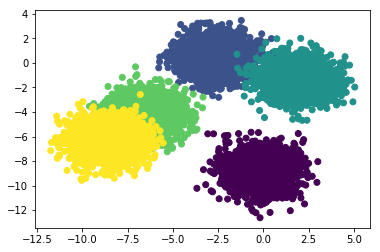

In [42]:
from sklearn.datasets import make_blobs
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

x, y = make_blobs(n_samples=10000, n_features=2, centers=5, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=5678)
plt.scatter(x[:,0], x[:, 1], c=y) #Реальное

In [43]:
gkf = KFold(n_splits=5, shuffle=True)

0.952
0.9525
0.9545
0.948
0.9535


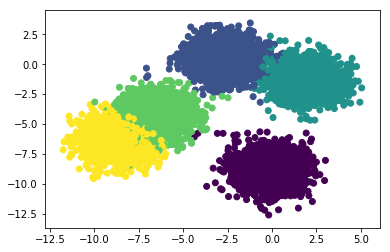

In [44]:
for train, test in gkf.split(x, y):
    X_train, y_train = x[train], y[train]
    X_test, y_test = x[test], y[test]
    my_clf.fit(X_train, y_train)
    y_pr = my_clf.predict(X_test)
    print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    plt.scatter(X_test[:,0], X_test[:, 1], c=y_pr) #Мой

0.9535
0.9495
0.957
0.948
0.949


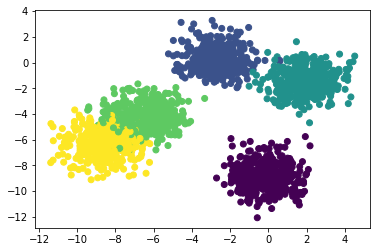

In [45]:
for train, test in gkf.split(x, y):
    X_train, y_train = x[train], y[train]
    X_test, y_test = x[test], y[test]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
plt.scatter(X_test[:,0], X_test[:, 1], c=y_pred) #SKLEARN

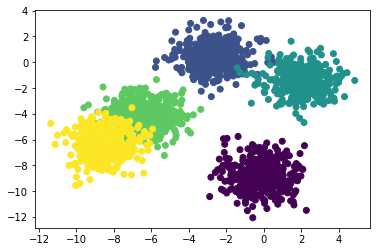

In [36]:
plt.scatter(X_test[:,0], X_test[:, 1], c=y_test) #Реальное

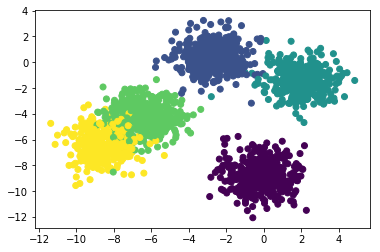

In [37]:
plt.scatter(X_test[:,0], X_test[:, 1], c=y_pred) #SKLEARN

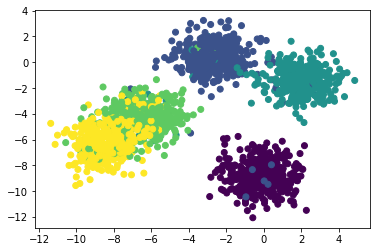

In [38]:
plt.scatter(X_test[:,0], X_test[:, 1], c=y_pr) #Мой